# Benchmark $R_{t}$ analysis

Analysis of results for a model with an unknown, time-varying Rt value. This model does not explicitly account for the presence of reporting bias.

In [1]:
import datetime
import os
import stan
import nest_asyncio

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '16'
plt.style.use('default')

import periodic_sampling as ps
from periodic_sampling.synthetic_data import RenewalModel, Reporter

In [2]:
# Used for smoothing stepped R profile

def smoothen_Rt(my_list, window):
    f_padding = [my_list[0]] * window
    smooth_list = list(pd.Series(f_padding + my_list).rolling(window=window, min_periods=1, center=True).mean())
    return smooth_list[window:]

In [3]:
# Simulate Renewal Model - same parameters as in benchmark_analysis
time_steps = 100; N_0 = 100; seed=42; R0_diff = 0.25
start_date = '01/01/2020'; bias_method = 'scale'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))
images_path = "full_model/synthetic_inference/stepped_R/"

np.random.seed(seed)
model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list);

# Report unbiased and biased data
rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 68089.35it/s]


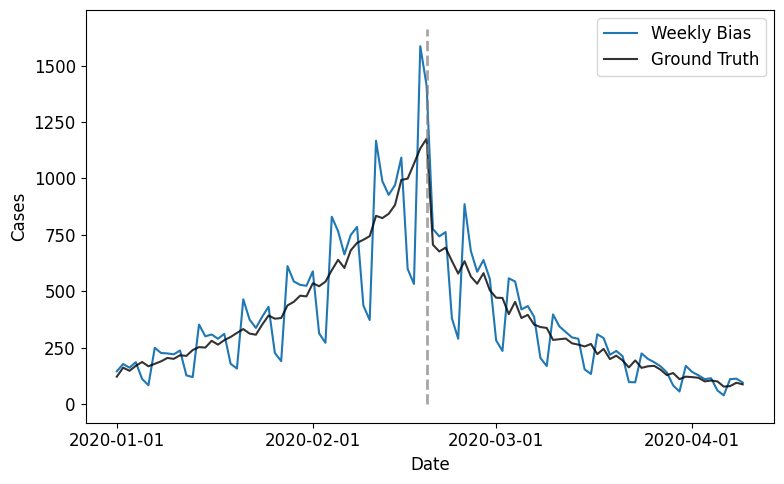

In [4]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
plt.vlines(x=mid_date, ymin=0, ymax=plt.gca().get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases"); axs.set_xticks(axs.get_xticks()[::2]);
plt.legend(); plt.tight_layout()

In [25]:
## Bias free inference code 

fixed_bias_code = """
//
// Model only infers a time-varying Rt value
// Assumes perfect knowledge of the underlying bias model
//

functions {
    int min_of_int_pair(int value_1, int value_2) {
        if (value_1 < value_2)
            return value_1;
        else {
            return value_2;
        }
    }
    real calculate_lambda(array[] real I, vector omega, int max_t) {
            if (max_t == 1)
                return I[1];
            int n_terms_lambda = min_of_int_pair(max_t, size(omega) - 1);  // Number of terms in sum for lambda

            vector[size(omega)] temp_omega;
            if (max_t < size(omega)) {
                temp_omega = omega ./ sum(omega[:n_terms_lambda+1]);
            }
            else {
                temp_omega = omega;
            }
            real total = 0;
            for(i in 1:n_terms_lambda) {
                total += (temp_omega[i+1] * I[max_t - i + 1]);
            }
            return total;
    }
}
data {
    int time_steps;
    int Rt_window;
    array[time_steps] int<lower=0> I;  // Length of biased timeseries must be known at compile time
    vector[20] serial_interval;  // 20 unit vectors generated in renewal_model.py
}
parameters {
    array[time_steps] real<lower=0> R;  // Time-varying, unknown reproduction number
}
model {
    
    for(i in 1:time_steps) {
        // P(I_t | R_t, Lambda_t) - Renewal Model
        int window_width;
        if (i < Rt_window)
            window_width = i;
        else {
            window_width = Rt_window;
        }

        for(j in 1:window_width){
            real mu = R[i] * calculate_lambda(I, serial_interval, i-(j-1));
            I[i-(j-1)] ~ normal(mu, sqrt(mu));
        }
    }

    R ~ gamma(1,1);
}
"""

In [45]:
nest_asyncio.apply()  # Required to run pystan in jupyter notebooks
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab

# with open(os.path.join(os.getcwd(), "full_model/full_model.stan")) as f:
#     fixed_bias_code = f.read()

c_val = list(bias_df['Confirmed'])

# Estimate true values using a rolling average
i_val = [int(val) for val in bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()]


fixed_bias_data = {
    "time_steps": len(c_val),
    "I": i_val,
    "Rt_window": 2,
    "serial_interval": RenewalModel(R0=None).serial_interval,
}

posterior = stan.build(fixed_bias_code, data=fixed_bias_data, random_seed=1) 

chain_num = 4
sample_num = int(2e3)
rt_init_val = [1 for _ in range(fixed_bias_data['time_steps'])]
init_values = [{'R': rt_init_val} for _ in range(chain_num)] 

fit = posterior.sample(num_chains=chain_num, num_samples=sample_num, 
                       num_thin=int(2e1),
                       init=init_values,
                       )
df = fit.to_frame()
output = df[df.columns.drop([c for c in df.columns if c.startswith('alpha')])]
print(output.describe().T)

Building: found in cache, done.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:   4% (500/12000)
Sampling:   7% (800/12000)
Sampling:  11% (1300/12000)
Sampling:  15% (1800/12000)
Sampling:  20% (2400/12000)
Sampling:  24% (2900/12000)
Sampling:  30% (3600/12000)
Sampling:  37% (4400/12000)
Sampling:  42% (5000/12000)
Sampling:  50% (6000/12000)
Sampling:  59% (7100/12000)
Sampling:  68% (8100/12000)
Sampling:  74% (8900/12000)
Sampling:  84% (10100/12000)
Sampling:  89% (10700/12000)
Sampling:  93% (11200/12000)
Sampling:  99% (11900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 8.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location paramet

               count        mean       std         min         25%  \
parameters                                                           
lp__           400.0 -734.795057  6.952201 -759.983562 -739.478285   
accept_stat__  400.0    0.851566  0.130562    0.395885    0.763555   
stepsize__     400.0    0.451157  0.011961    0.431868    0.446115   
treedepth__    400.0    3.067500  0.251200    3.000000    3.000000   
n_leapfrog__   400.0    7.880000  2.506253    7.000000    7.000000   
...              ...         ...       ...         ...         ...   
R.96           400.0    0.785490  0.050190    0.624296    0.752627   
R.97           400.0    0.798245  0.051048    0.660013    0.761256   
R.98           400.0    0.793927  0.051447    0.660729    0.760349   
R.99           400.0    0.779068  0.056120    0.624044    0.740777   
R.100          400.0    0.782716  0.056372    0.635458    0.749042   

                      50%         75%         max  
parameters                           

In [46]:
def rename_col(col):
    col = col.replace('.', '_')
    return col[:5] + str(int(col[5:])-1) if col.startswith('bias') else col

step_num = 5000; images_path = "stepped_profile/"; 

output.columns = map(rename_col, output.columns)  # Only run this once!

Average error: 8.5845%


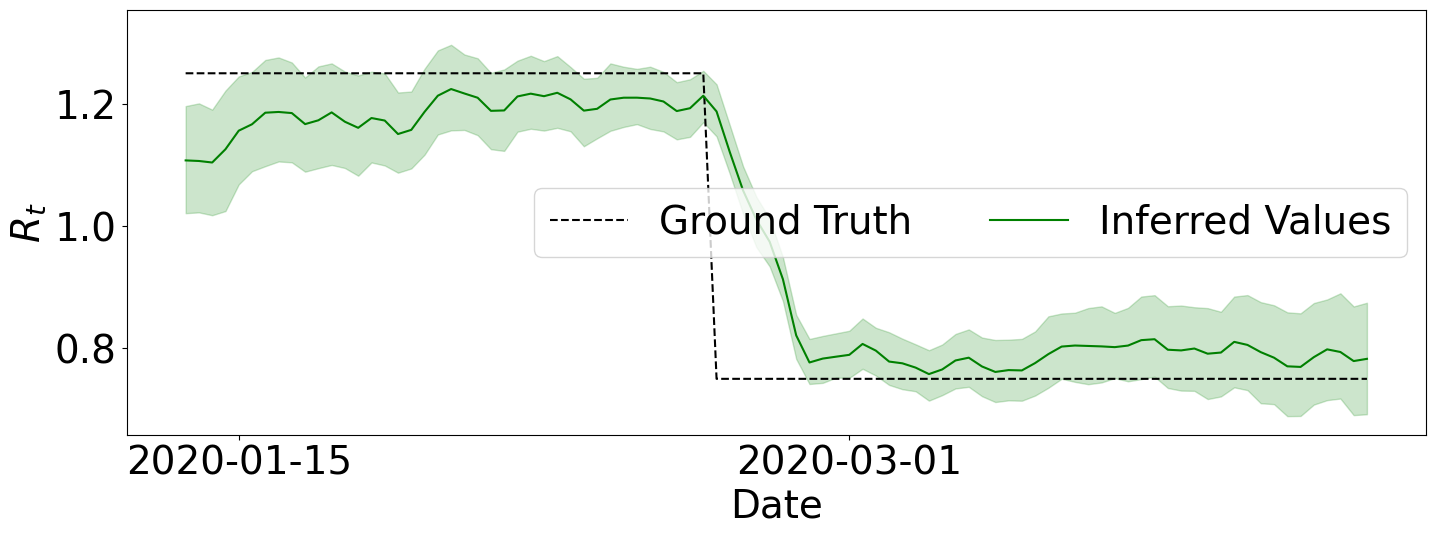

In [48]:
plt.rcParams['font.size'] = '28'; interval_range = 90; window = 10
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


for index in range(1, time_steps+1):
    predicted_R.append(np.mean(output['R_' + str(index)]))
    upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
    lower_R.append(np.percentile(output['R_' + str(index)], percentile))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(15, 6))

ax.plot(truth_df['Date'][window:], R0_list[window:], color='black', label = 'Ground Truth', linestyle = 'dashed')
ax.plot(truth_df['Date'][window:], predicted_R[window:], color='green', label = 'Inferred Values')
ax.fill_between(truth_df['Date'][window:], lower_R[window:], upper_R[window:], color = 'green', alpha=0.2)
ax.set_ylim([ax.get_ylim()[0],ax.get_ylim()[1]*1.02])
ax.set_xticks(ax.get_xticks()[::3]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("$R_{t}$")
plt.legend(ncol=2); plt.tight_layout()
# plt.savefig(images_path + f"Rt_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_Rn_{R_n}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}_win_2.png")

diff = np.sqrt(np.square(np.array(R0_list) - np.array(predicted_R)))
print(f"Average error: {100 * np.mean(diff / R0_list):.4f}%")

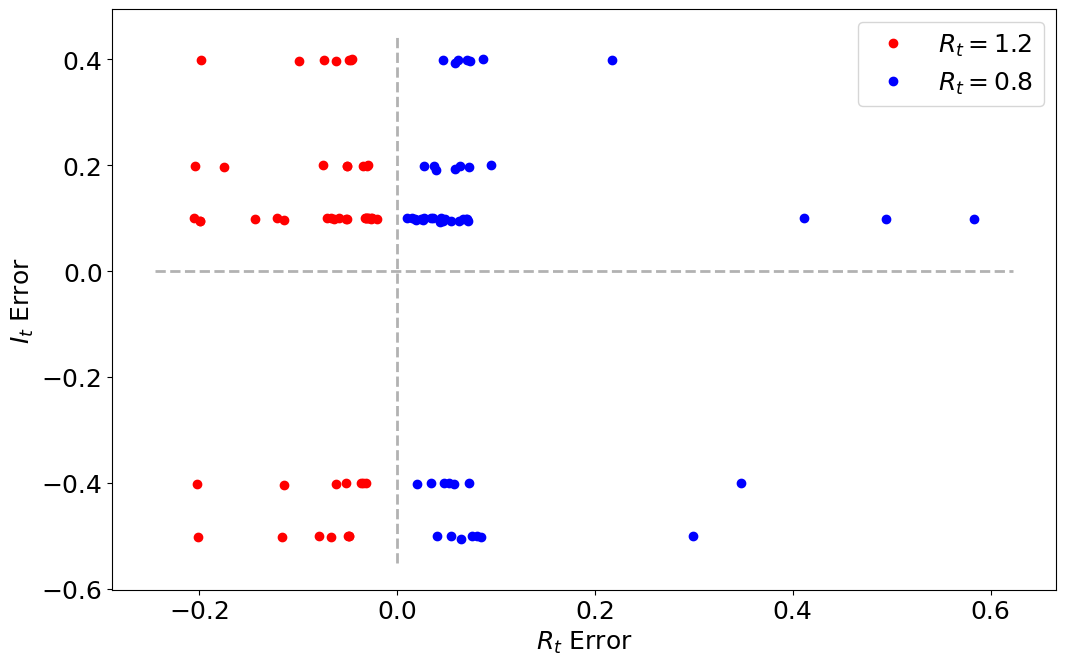

In [49]:
plt.rcParams['font.size'] = '18'
colors = ['r', 'b']; R_val = [1 + R0_diff, 1 - R0_diff]

if 'R_1' in output.columns:
    fig, axs = plt.subplots(1, 1, figsize=(11,7))
    for t in range(time_steps):
        if ('Chain' not in output.columns):
            output['Chain'] = 1
        chains = output['Chain'].unique()
        for chain in chains:
            index = output.index[output['Chain']==chain]
            axs.plot(
                np.mean((output['R_' + str(t+1)][output['Chain']==chain]) - R_val[t // int(time_steps /2)]) / R_val[t // int(time_steps /2)],
                # np.mean(output['bias_' + str(t % 7)][output['Chain']==chain]) - bias[(t + start_index) % 7],
                (c_val[t] - truth_df['Confirmed'][t]) / truth_df['Confirmed'][t],
                marker='o', color = colors[t // int(time_steps /2)], linestyle = '')

    axs.hlines(y=0, xmin=axs.get_xlim()[0], xmax=axs.get_xlim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.vlines(x=0, ymin=axs.get_ylim()[0], ymax=axs.get_ylim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.set_xlabel(r'$R_{t}$ Error'); axs.set_ylabel(r'$I_{t}$ Error'); axs.set_title('');
    axs.lines[1].set_label(r'$R_{t} = 1.2$'); axs.lines[-1].set_label(r'$R_{t} = 0.8$')

    plt.gcf().patch.set_facecolor('white'); plt.legend(); plt.tight_layout();
    # plt.savefig(images_path + f"error_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

RMS Residual for Biased data: 142.65
RMS Residual for Rolling Average data: 84.14


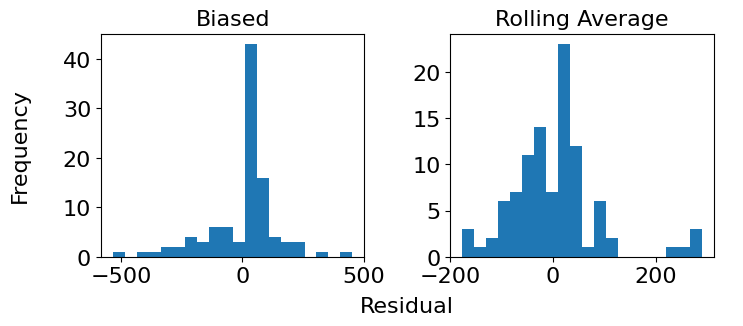

In [50]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

roll_ave_series = bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()
data_series = [bias_df['Confirmed'], roll_ave_series]
labels = ['Biased', 'Rolling Average']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(8,4))
for i in range(len(data_series)):
    residual = data_series[i] - truth_df['Confirmed']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_residuals_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

Expected lag for Biased data: -0.02 days
Expected lag for Rolling Average data: 2.02 days


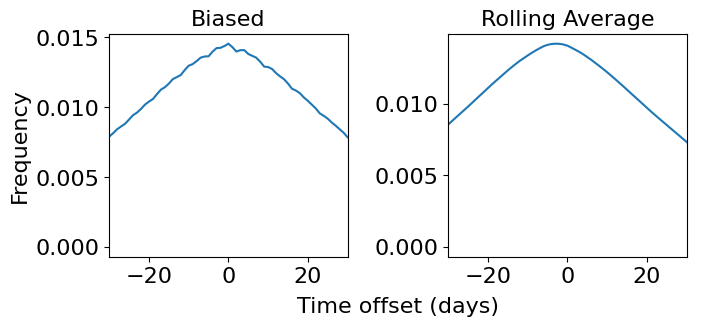

In [51]:
fig, axs = plt.subplots(1, len(data_series), figsize=(8,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(truth_df['Confirmed'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(truth_df['Confirmed']) + 1, len(truth_df['Confirmed']))
    expected_lag = np.dot(t_values, cross_corr)
    
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  # Normalise by number of contributing elements from timeseries
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_crosscorr_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")